INFO:tensorflow:Restoring parameters from vae_models/depth_5_epochs/model
loaded model weights from models/depth_5_epochs/model
INFO:tensorflow:Restoring parameters from vae_models/RGB_1_epochs/model
loaded model weights from models/RGB_1_epochs/model
INFO:tensorflow:Restoring parameters from vae_models/sem_1_epochs/model
loaded model weights from models/sem_1_epochs/model
INFO:tensorflow:Restoring parameters from vae_models/full_1_epochs/model
loaded the vae model weights frommodels/full_1_epochs/model


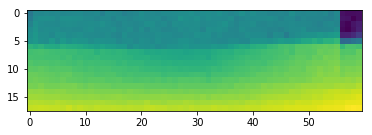

In [9]:
# %load VAE_full.py
#This is VAE_depth script 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.4
tf.reset_default_graph()

def xavier_init(fan_in, fan_out, constant=1): 
	""" Xavier initialization of network weights"""
	# https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
	low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
	high = constant*np.sqrt(6.0/(fan_in + fan_out))
	# return tensors
	return tf.random_uniform((fan_in, fan_out), #  shape of the weights
							 minval=low, maxval=high, # here is the range 
							 dtype=tf.float32) # here is the type


class VariationalAutoencoder(object):
	""" Based on See "Auto-Encoding Variational Bayes" by Kingma and Welling
	"""
	def __init__(self, network_architecture,
				 transfer_fct=tf.nn.softplus,learning_rate=1e-3,batch_size=100):
		self.network_architecture=network_architecture# which is a dictionary 
		self.transfer_fct=transfer_fct
		self.learning_rate=learning_rate
		self.batch_size=batch_size
		# tf Graph input
		self.x=tf.placeholder(tf.float32,[None, network_architecture["n_input"]])
		# Create auotencoder 
		self.create_network()
		# define loss function based on variational upper bound 
		# and corresponding optimizer 
		self.create_loss_optimizer()
		#self.saver=tf.train.Saver()


	def initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
							n_hidden_gener_1,  n_hidden_gener_2, 
							n_input, n_z):
		# create a dictionary of tensor variables 
		all_weights = dict()
		# recognition  network
		all_weights['weights_recog'] = {
			'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
			'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
			'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
			'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
		all_weights['biases_recog'] = {
			'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
			'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
			'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
			'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
		# generate network 
		all_weights['weights_gener'] = {
			'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
			'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
			'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
			'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
		all_weights['biases_gener'] = {
			'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
			'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
			'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
			'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
		return all_weights
	
	def create_network(self):
		# create tensor variables for  weights and bias
		self.network_weights=self.initialize_weights(**self.network_architecture) 
		# network_weights  is a dictionary 
		# pass architecture parameters 
		# network_architecture is a dictionary 

		# recognition network :
		#input: data x shape [batch_size,n_x]
		#output : mean of z , log(variance^2) shape [batch_size,n_z]
		# pass variables to network 
		self.z_mean, self.z_log_sigma_sq = \
			self.recognition_network(self.network_weights["weights_recog"], 
									 self.network_weights["biases_recog"])
			
		n_z = self.network_architecture["n_z"]# dimension of z
		
		
		eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32) 
		# standard Normal
		# z = z_mean + z_sigma*epsilon
		
		self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
		#shape [batch_size,n_z]
		
		# Generate network :
		# input z
		# output mean of pixels shape[batch_Size,n_x]
		# multivariant Gaussian Distribution
		self.x_reconstr_mean = \
			self.generator_network(self.network_weights["weights_gener"],
								   self.network_weights["biases_gener"])
	
	def recognition_network(self, weights, biases):
		# Generate probabilistic encoder (recognition network), which
		# maps inputs onto a normal distribution in latent space.
		# The transformation is parametrized and can be learned.
		layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
										   biases['b1'])) 
		layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
										   biases['b2'])) 
		z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
						biases['out_mean'])
		
		z_log_sigma_sq =\
			tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
				   biases['out_log_sigma'])
			
		return (z_mean, z_log_sigma_sq)
	
	# use variables to buld generate network 
	def generator_network(self, weights, biases):
		# Generate probabilistic decoder (decoder network), which
		# maps points in latent space onto a Bernoulli distribution in data space.
		# The transformation is parametrized and can be learned.
		layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
										   biases['b1'])) 
		layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
										   biases['b2'])) 
		
		# depth estimation mean 
		x_reconstr_mean = \
		   tf.add(tf.matmul(layer_2, weights['out_mean']), 
								 biases['out_mean'])
		#x_reconstr_sigma= \
		#     tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
		#                        biases['out_log_sigma'])
		return x_reconstr_mean
	
	def create_loss_optimizer(self):
		# The loss is composed of two terms:
		
		# 1.) The reconstruction loss (the negative log probability
		#     of the input under the reconstructed Bernoulli/Gaussian distribution 
		#     induced by the decoder in the data space).
		#     This can be interpreted as the number of "nats" required
		#     for reconstructing the input when the activation in latent
		#     is given.
		# Adding 1e-10 to avoid evaluation of log(0.0)
		# Assuem identity gaussian 
		
		# loss from generative data 
 
		# 1) bernouli distribution
		"""
		reconstr_loss =-tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
						   + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
						   axis=1)
		"""
		# 1) gaussian distribution
		reconstr_error=self.x-self.x_reconstr_mean
		reconstr_loss=tf.reduce_sum(tf.square(reconstr_error),axis=1)
		# 2.) The latent loss, which is defined as the Kullback Leibler divergence 
		##    between the distribution in latent space induced by the encoder on 
		#     the data and some prior. This acts as a kind of regularizer.
		#     This can be interpreted as the number of "nats" required
		#     for transmitting the the latent space distribution given
		#     the prior.
		#     closed form of  KL  divergence with gaussian distribution
		latent_loss=-0.5*tf.reduce_sum(1+self.z_log_sigma_sq 
										   -tf.square(self.z_mean) 
										   -tf.exp(self.z_log_sigma_sq), axis=1)
		self.cost = tf.reduce_mean(reconstr_loss + latent_loss) # average over batch
		# Use ADAM optimizer
		self.optimizer = \
			tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
			

	def partial_fit(self, X):
		"""
		Train model based on mini-batch of input data.
		Return cost of mini-batch.
		"""
		opt,cost = sess.run((self.optimizer, self.cost), 
								  feed_dict={self.x: X})
		return cost


	def train(self, batch_size=100, training_epochs=10, display_step=1):
		print("training started ...")
		train_indices=range(n_samples)
		for epoch in range(training_epochs):
			avg_cost = 0.
			total_batch = int(n_samples / batch_size)
			perm_indices=np.random.permutation(train_indices)
		# Loop over all batches
			for i in range(total_batch):
				offset=(i*batch_size)%(n_samples-batch_size)
				# mnist data  batch_xs, _ = mnist.train.next_batch(batch_size)
				batch_indices=perm_indices[offset:(offset+batch_size)]
				# feed the data for full models 
				batch_xs=z_in[batch_indices]
			# Fit training using batch data
				cost = self.partial_fit(batch_xs)
			# Compute average loss
				avg_cost += cost/n_samples*batch_size
		# Display logs per epoch step
			if epoch % display_step == 0:
				print("Epoch:", '%04d' % (epoch+1), 
					  "cost=", "{:.9f}".format(avg_cost))




#Build  network for depth channel
with tf.variable_scope("depth"):
	network_architecture_depth= \
	   dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
		 n_hidden_recog_2=1000, # 2nd layer encoder neurons
		 n_hidden_gener_1=1000, # 1st layer decoder neurons
		 n_hidden_gener_2=1000, # 2nd layer decoder neurons
		 n_input=1080, # MNIST data input (img shape: 28*28)
		 n_z=50)  # dimensionality of latent space
	vae_depth=VariationalAutoencoder(network_architecture_depth,learning_rate=0.001,batch_size=100)

listvar=vae_depth.network_weights
var_depth=(list(listvar['weights_recog'].values())
	+list(listvar['biases_recog'].values())
	+list(listvar['weights_gener'].values())
	+list(listvar['biases_gener'].values()))
saver_depth=tf.train.Saver(var_depth)


# Build network for semantics  channel
with tf.variable_scope("RGB"):
	network_architecture_rgb= \
		dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
			n_hidden_recog_2=1000, # 2nd layer encoder neurons
			n_hidden_gener_1=1000, # 1st layer decoder neurons
			n_hidden_gener_2=1000, # 2nd layer decoder neurons
			n_input=1080*3, # MNIST data input (img shape: 28*28)
			n_z=50)  # dimensionality of latent space
	vae_rgb=VariationalAutoencoder(network_architecture_rgb,learning_rate=0.001,batch_size=100)
    
listvar2=vae_rgb.network_weights
var_rgb=(list(listvar2['weights_recog'].values())
	+list(listvar2['biases_recog'].values())
	+list(listvar2['weights_gener'].values())
	+list(listvar2['biases_gener'].values()))
saver_rgb=tf.train.Saver(var_rgb)


# Build network for semantic channels
with tf.variable_scope("Sem"):
	network_architecture_Sem = \
		dict(n_hidden_recog_1=2000, # 1st layer encoder neurons
		 n_hidden_recog_2=2000, # 2nd layer encoder neurons
		 n_hidden_gener_1=2000, # 1st layer decoder neurons
		 n_hidden_gener_2=2000, # 2nd layer decoder neurons
		 n_input=5400, # MNIST data input (img shape: 28*28)
		 n_z=100)  # dimensionality of latent space
	vae_Sem=VariationalAutoencoder(network_architecture_Sem,learning_rate=1e-4,batch_size=100)

listvar3=vae_Sem.network_weights
var_Sem=(list(listvar3['weights_recog'].values())
	+list(listvar3['biases_recog'].values())
	+list(listvar3['weights_gener'].values())
	+list(listvar3['biases_gener'].values()))
saver_Sem=tf.train.Saver(var_Sem)


########################    Start build  shared information fusion   #############################



########################    Start build  shared information fusion   #############################
############## Load data ####################
depth_data=np.load("../Data/depth_data.npy")
Depth_input=np.transpose(depth_data,(0,2,1,3))[:,:,:,0].reshape(-1,1080)# shape [size,1080]

RGB_data=np.load("../Data/rgb_data.npy")
R_data=RGB_data[:,:,:,0].reshape(-1,1080)
G_data=RGB_data[:,:,:,1].reshape(-1,1080)
B_data=RGB_data[:,:,:,2].reshape(-1,1080)
RGB_input=np.concatenate((R_data,G_data,B_data),axis=1) #shape[size,3*1080]

Sem_data=np.load("../Data/sem_data.npy")
Sem_input=np.transpose(Sem_data,(0,2,1,3))
Ground_input=Sem_input[:,:,:,0].reshape(-1,1080)
Objects_input=Sem_input[:,:,:,1].reshape(-1,1080)
Building_input=Sem_input[:,:,:,2].reshape(-1,1080)
Vegetation_input=Sem_input[:,:,:,3].reshape(-1,1080)
Sky_input=Sem_input[:,:,:,4].reshape(-1,1080)
Sem_input=np.concatenate((Ground_input,Objects_input,
						  Building_input,Vegetation_input,Sky_input),
						  axis=1)# shape[size,5*1080]

n_samples=Sem_input.shape[0] # size 
############## Finish Load data ####################



with tf.variable_scope("Full"):
	network_architecture_Full = \
		dict(n_hidden_recog_1=50, # 1st layer encoder neurons
		 n_hidden_recog_2=50, # 2nd layer encoder neurons
		 n_hidden_gener_1=50, # 1st layer decoder neurons
		 n_hidden_gener_2=50, # 2nd layer decoder neurons
		 n_input=200, # MNIST data input (img shape: 28*28)
		 n_z=2)  # dimensionality of latent space
	#vae_Sem= VariationalAutoencoder(network_architecture_Sem,learning_rate=1e-4, batch_size=100)
	vae_Full=VariationalAutoencoder(network_architecture_Full,learning_rate=1e-4,batch_size=100)



### Initialization
init=tf.global_variables_initializer()
sess=tf.Session(config=config)
sess.run(init)

###Load  other models 
saver_depth.restore(sess,"vae_models/depth_5_epochs/model")
print("loaded model weights from "+"models/depth_5_epochs/model")

saver_rgb.restore(sess,"vae_models/RGB_1_epochs/model")
print("loaded model weights from "+"models/RGB_1_epochs/model")

saver_Sem.restore(sess,"vae_models/sem_1_epochs/model")
print("loaded model weights from "+"models/sem_1_epochs/model")


###Build data for full model 
z_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input})
z_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input})
z_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input})
#z_in is the data required 
z_in=np.concatenate((z_rgb,z_depth,z_sem),axis=1)


######################## variables list #########################
listvar4=vae_Full.network_weights
var_Full=(list(listvar4['weights_recog'].values())
	+list(listvar4['biases_recog'].values())
	+list(listvar4['weights_gener'].values())
	+list(listvar4['biases_gener'].values()))
saver_Full=tf.train.Saver(var_Full)


train_new_model=False
if train_new_model:    
	vae_Full.train(batch_size=100, training_epochs=1)
	saver_Full.save(sess,"vae_models/full_1_epochs/model")
	print("saved the vae model weights to "+"models/full_1_epochs/model")
else:
	saver_Full.restore(sess,"vae_models/full_1_epochs/model")
	print("loaded the vae model weights from"+"models/full_1_epochs/model")

	z_out=sess.run(vae_Full.x_reconstr_mean,feed_dict={vae_Full.x:z_in[0:100,:]})
	z_out_rgb,z_out_depth,z_out_sem=np.split(z_out, [50,100],axis=1)
	rgb_out=sess.run(vae_rgb.x_reconstr_mean,feed_dict={vae_rgb.z:z_out_rgb})# shape [size,3240]
	depth_image=sess.run(vae_depth.x_reconstr_mean,feed_dict={vae_depth.z:z_out_depth})# shape [size,1080]
	sem_out=sess.run(vae_Sem.x_reconstr_mean,feed_dict={vae_Sem.z:z_out_sem})# shape[size,5400]

	red_out,green_out,blue_out=np.split(rgb_out,3,axis=1)
	RGB_image=np.dstack((red_out,green_out,blue_out))

	G_out,O_out,V_out,B_out,S_out=np.split(sem_out,5,axis=1)
	Sem_image=np.dstack((G_out,O_out,V_out,B_out,S_out))
	plt.imshow(np.reshape(depth_image[0],(18,60)))

sess.close()